In [54]:
#from envs.LinearBertrandInflation_final3 import LinearBertrandEnv
from envs.LinearBertrandInflation_profe import LinearBertrandEnv
from envs.BertrandInflation_profe import BertrandEnv
from agents.sac_moving4 import SACAgent
from replay_buffer_final import ReplayBuffer
from tqdm import tqdm
import numpy as np

N = 2
k = 10
rho = 1e-4
#total_timesteps = 30_000
total_timesteps = 100_000
episodes = 1
inflation_start = 0

#env = LinearBertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, moving_dim = 200, use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
env = BertrandEnv(N = N, k = k, rho = rho, v = int(k * 1.5), timesteps = total_timesteps, 
                  use_moving_avg=True, inflation_start=inflation_start, max_var = 2.0)
dim_states = N * k + k + 1
agents = [SACAgent(dim_states, 1, gamma=0.95, actor_lr=3e-4, Q_lr=3e-4, alpha_lr=3e-4) for agent in range(env.N)]

buffer = ReplayBuffer(dim_states=dim_states, N = env.N, sample_size = 256, buffer_size = 1000000)

prices_history = np.zeros((episodes, total_timesteps, N))
actions_history = np.zeros((episodes, total_timesteps, N))
costs_history = np.zeros((episodes, total_timesteps))
monopoly_history = np.zeros((episodes, total_timesteps))
nash_history = np.zeros((episodes, total_timesteps))
rewards_history = np.zeros((episodes, total_timesteps, N))
delta_history = np.zeros((episodes, total_timesteps))
quantities_history = np.zeros((episodes, total_timesteps, N))
pi_N_history = np.zeros((episodes, total_timesteps))
pi_M_history = np.zeros((episodes, total_timesteps))
A_history = np.zeros((episodes, total_timesteps))

for episode in range(episodes):
    ob_t = env.reset()
    for timestep in tqdm(range(total_timesteps)):
        
        actions = [agent.select_action(ob_t) for agent in agents]
        
        ob_t1, rewards, done, _ = env.step(actions)
        
        experience = (ob_t, actions, rewards, ob_t1, done)
        buffer.store_transition(*experience)
        
        if timestep > buffer.sample_size:
            for agent_idx in range(N):
                agent = agents[agent_idx]
                sample = buffer.sample(agent_idx)
                agent.update(*sample)
        
        ob_t = ob_t1
        
    # store metrics
    prices_history[episode] = np.array(env.prices_history)[-total_timesteps:]
    actions_history[episode] = np.array(env.action_history)[-total_timesteps:]
    costs_history[episode] = np.array(env.costs_history)[-total_timesteps:]
    monopoly_history[episode] = np.array(env.monopoly_history)[-total_timesteps:]
    nash_history[episode] = np.array(env.nash_history)[-total_timesteps:]
    rewards_history[episode] = np.array(env.rewards_history)[-total_timesteps:]
    delta_history[episode] = np.array(env.metric_history)[-total_timesteps:]
    quantities_history[episode] = np.array(env.quantities_history)[-total_timesteps:]
    pi_N_history[episode] = np.array(env.pi_N_history)[-total_timesteps:]
    pi_M_history[episode] = np.array(env.pi_M_history)[-total_timesteps:]
    A_history[episode] = np.array(env.A_history)[-total_timesteps:]
    
prices_history = np.mean(prices_history, axis = 0)
actions_history = np.mean(actions_history, axis = 0)
costs_history = np.mean(costs_history, axis = 0)
monopoly_history = np.mean(monopoly_history, axis = 0)
nash_history = np.mean(nash_history, axis = 0)
rewards_history = np.mean(rewards_history, axis = 0)
delta_history = np.mean(delta_history, axis = 0)
quantities_history = np.mean(quantities_history, axis = 0)
pi_N_history = np.mean(pi_N_history, axis = 0)
pi_M_history = np.mean(pi_M_history, axis = 0)
A_history = np.mean(A_history, axis = 0) # equal disposition to pay

100%|██████████| 100000/100000 [37:11<00:00, 44.81it/s] 


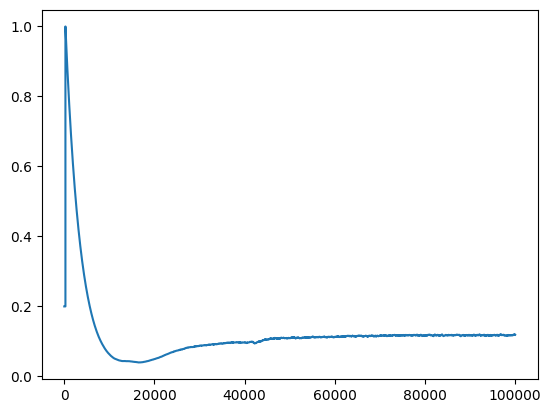

In [55]:
import matplotlib.pyplot as plt
plt.plot(agents[0].alpha_history)

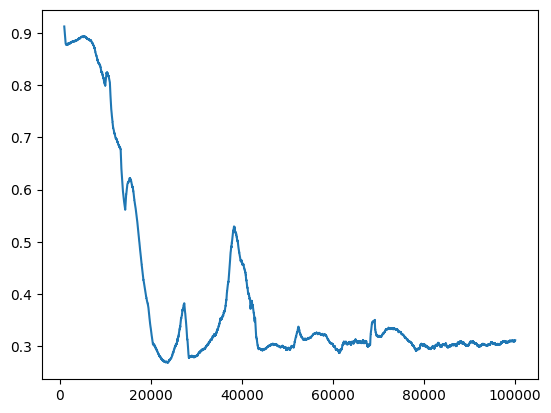

In [56]:
from utils.plot_metrics import get_rolling

plt.plot(get_rolling(agents[0].std_history, 1000))

In [57]:
import pandas as pd

results = pd.DataFrame({'costs': costs_history,
                        'pi_N': pi_N_history,
                        'pi_M': pi_M_history,
                        'delta': delta_history,
                        'p_nash': nash_history,
                        'p_monopoly': monopoly_history,
                        'A': A_history,
                        })

for agent in range(env.N):
    results[f'actions_{agent}'] = actions_history[:, agent]
    results[f'prices_{agent}'] = prices_history[:, agent]
    results[f'quantities_{agent}'] = quantities_history[:, agent]
    results[f'rewards_{agent}'] = rewards_history[:, agent]

results.to_csv(f'test.csv', index = False, sep = ';', encoding = 'utf-8-sig')
results

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1
0,1.000000,0.299471,0.343706,-0.601792,1.799471,2.187411,2.000000,0.296193,1.592387,0.510615,0.302482,0.461663,1.923325,0.263417,0.243220
1,1.000000,0.299471,0.343706,-5.829094,1.799471,2.187411,2.000000,0.630780,2.261559,0.065986,0.083245,-0.267833,1.000000,0.822677,0.000000
2,1.000000,0.299471,0.343706,-6.591962,1.799471,2.187411,2.000000,0.017468,1.034936,0.450958,0.015755,-0.960002,1.000000,0.483595,0.000000
3,1.000000,0.299471,0.343706,-5.346520,1.799471,2.187411,2.000000,0.311871,1.623742,0.201908,0.125938,-0.764347,1.000000,0.702957,0.000000
4,1.000000,0.299471,0.343706,-0.126476,1.799471,2.187411,2.000000,0.377970,1.755941,0.552621,0.417749,0.785663,2.571326,0.108191,0.170004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.164455,0.299471,0.343706,-1.087397,1.963926,2.351866,2.164455,0.219518,1.675691,0.603623,0.308595,0.492491,2.311423,0.169269,0.194146
99996,1.164455,0.299471,0.343706,0.715750,1.963926,2.351866,2.164455,0.562855,2.475293,0.279330,0.366156,0.633995,2.640971,0.200545,0.296107
99997,1.164455,0.299471,0.343706,-3.538143,1.963926,2.351866,2.164455,0.091497,1.377544,0.735713,0.156772,0.495988,2.319567,0.111809,0.129152
99998,1.164455,0.299471,0.343706,0.724646,1.963926,2.351866,2.164455,0.610828,2.587019,0.225529,0.320830,0.589249,2.536761,0.249377,0.342221


In [58]:
from utils.plot_metrics import get_rolling

window_size = 1000
df_plot = pd.read_csv('test.csv', sep = ';', encoding = 'utf-8-sig')

actions_cols = [col for col in df_plot.columns if 'actions' in col]
price_cols = [col for col in df_plot.columns if 'prices' in col]
rewards_cols = [col for col in df_plot.columns if 'rewards' in col]
quantities_cols = [col for col in df_plot.columns if 'quantities' in col]

n_agents = len(actions_cols)

df_plot['avg_actions'] = df_plot[actions_cols].mean(axis = 1)
df_plot['avg_prices'] = df_plot[price_cols].mean(axis = 1)
df_plot['avg_rewards'] = df_plot[rewards_cols].mean(axis = 1)
df_plot['avg_quantities'] = df_plot[quantities_cols].mean(axis = 1)
avg_cols = [col for col in df_plot.columns if 'avg' in col]

window_cols = price_cols + rewards_cols + quantities_cols + avg_cols + ['delta']
for col in window_cols:
    df_plot[col] = get_rolling(df_plot[col], window_size = window_size)

df_plot.tail()

,costs,pi_N,pi_M,delta,p_nash,p_monopoly,A,actions_0,prices_0,quantities_0,rewards_0,actions_1,prices_1,quantities_1,rewards_1,avg_actions,avg_prices,avg_rewards,avg_quantities
99995,1.164455,0.299471,0.343706,-1.482684,1.963926,2.351866,2.164455,0.219518,2.123065,0.361102,0.234904,0.492491,2.155143,0.341766,0.232866,0.408658,2.139104,0.233885,0.351434
99996,1.164455,0.299471,0.343706,-1.482806,1.963926,2.351866,2.164455,0.562855,2.123190,0.361129,0.234971,0.633995,2.155640,0.341585,0.232788,0.408791,2.139415,0.233879,0.351357
99997,1.164455,0.299471,0.343706,-1.486008,1.963926,2.351866,2.164455,0.091497,2.122711,0.361439,0.234833,0.495988,2.155998,0.341352,0.232643,0.408765,2.139355,0.233738,0.351396
99998,1.164455,0.299471,0.343706,-1.485090,1.963926,2.351866,2.164455,0.610828,2.123375,0.361106,0.234730,0.589249,2.155733,0.341505,0.232827,0.408851,2.139554,0.233778,0.351306
99999,1.164455,0.299471,0.343706,-1.485773,1.963926,2.351866,2.164455,0.241875,2.122254,0.361586,0.234806,0.705396,2.155612,0.341433,0.232690,0.408584,2.138933,0.233748,0.351509


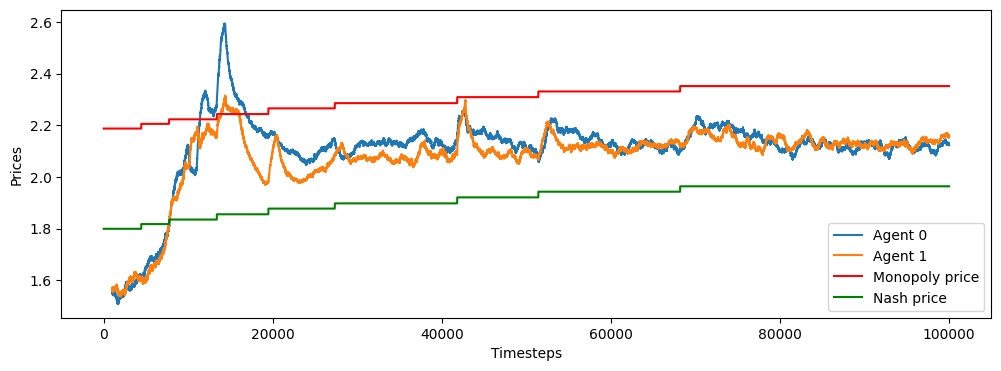

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
for agent in range(n_agents):
    price_serie = df_plot[f'prices_{agent}']
    plt.plot(price_serie, label = f'Agent {agent}')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

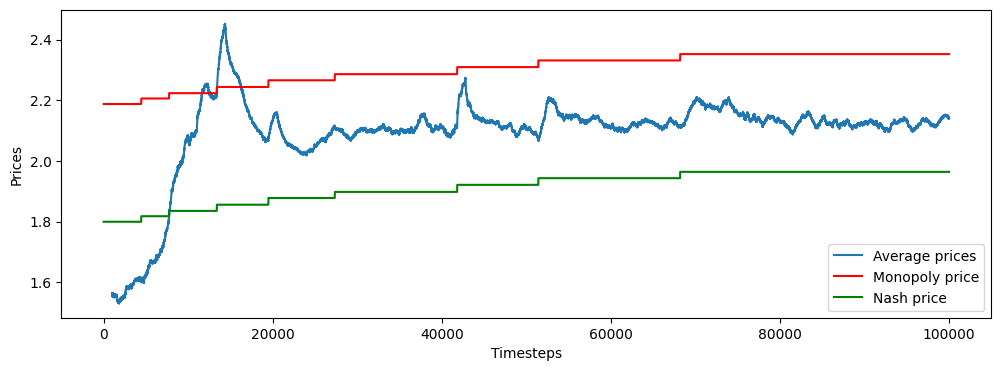

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 4))
plt.plot(df_plot['avg_prices'], label = 'Average prices')
plt.plot(df_plot['p_monopoly'], color = 'red', label = 'Monopoly price')
plt.plot(df_plot['p_nash'], color = 'green', label = 'Nash price')
plt.xlabel('Timesteps')
plt.ylabel('Prices')
plt.legend()
plt.savefig('plot.png')

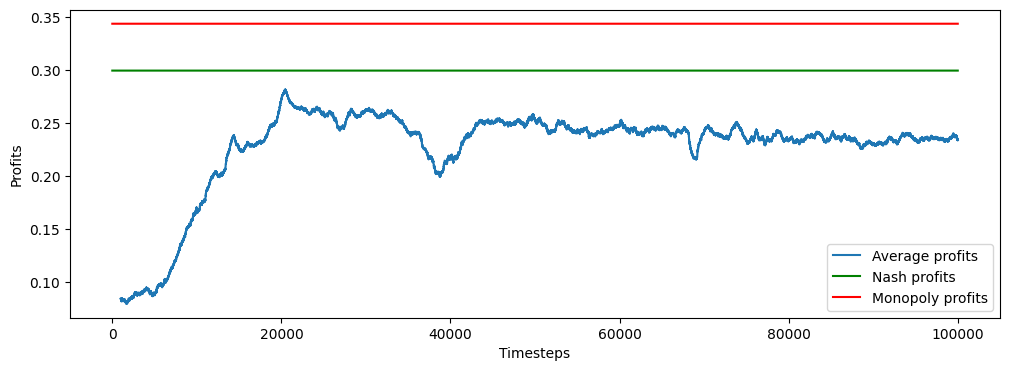

In [61]:
plt.figure(figsize = (12, 4))
plt.plot(df_plot['avg_rewards'], label = 'Average profits')
plt.plot(df_plot['pi_N'], label = 'Nash profits', color = 'green')
plt.plot(df_plot['pi_M'], label = 'Monopoly profits', color = 'red')
plt.xlabel('Timesteps')
plt.ylabel('Profits')
plt.legend()

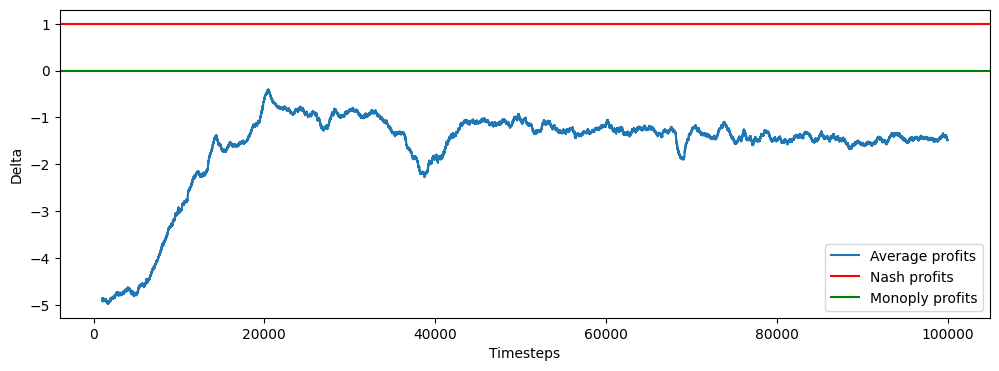

In [62]:
plt.figure(figsize = (12, 4))
plt.plot(df_plot['delta'], label = 'Average profits')
plt.axhline(1, color = 'red', label = 'Nash profits')
plt.axhline(0, color = 'green', label = 'Monoply profits')
plt.xlabel('Timesteps')
plt.ylabel('Delta')
plt.legend()

In [ ]:
df_plot